In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
import yfinance as yf

#1. Loading the Data:

In [ ]:
ticker_symbol = "RELIANCE.NS"
ticker = yf.Ticker(ticker_symbol)
start_date = '1997-05-15'
end_date = '2024-8-31'
df = ticker.history(start = start_date, end = end_date)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [ ]:
df = pd.read_csv("/content/NSE_RELIANCE, 1D (1).csv")

In [ ]:
df.head()

,time,open,high,low,close,EMA,Histogram,MACD,Signal,RSI,RSI-based MA,Upper Bollinger Band,Lower Bollinger Band,Regular Bullish,Regular Bullish Label,Regular Bearish,Regular Bearish Label
0,1994-11-03,25.855591,27.579300,25.855591,27.303512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-11-07,27.303512,27.458641,27.096663,27.269034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-11-08,27.441406,27.493118,27.096663,27.303512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-11-09,27.510353,27.510353,26.596790,26.682972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-11-10,26.682972,26.889821,26.200335,26.234812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.drop(["Upper Bollinger Band","Lower Bollinger Band","Regular Bullish", "Regular Bullish Label","Regular Bearish","Regular Bearish Label"], axis =1)

In [ ]:
new_df = df.iloc[35:].reset_index(drop = True)
new_df.head()

,time,open,high,low,close,EMA,Histogram,MACD,Signal,RSI,RSI-based MA
0,1994-12-26,23.373457,23.769913,23.342429,23.373457,23.690058,0.009401,-0.754695,-0.764097,35.358675,33.029386
1,1994-12-27,23.442404,23.442404,23.190743,23.287275,23.609502,0.016032,-0.744057,-0.760089,34.742132,32.920340
2,1994-12-28,23.476881,23.476881,23.390692,23.390692,23.565740,0.032877,-0.718993,-0.751870,36.180207,33.086130
3,1994-12-29,23.407934,23.425169,23.356222,23.387249,23.530042,0.048346,-0.691437,-0.739783,36.151652,33.124522
4,1994-12-30,23.373457,23.545829,23.373457,23.525144,23.529062,0.071052,-0.650968,-0.722020,38.254164,33.786416


In [ ]:
new_df.isnull().sum()

,0
time,0
open,0
high,0
low,0
close,0
EMA,0
Histogram,0
MACD,0
Signal,0
RSI,0


In [ ]:
new_df = new_df.rename(columns= {"time":"Date"})
new_df.head()

,Date,open,high,low,close,EMA,Histogram,MACD,Signal,RSI,RSI-based MA
0,1994-12-26,23.373457,23.769913,23.342429,23.373457,23.690058,0.009401,-0.754695,-0.764097,35.358675,33.029386
1,1994-12-27,23.442404,23.442404,23.190743,23.287275,23.609502,0.016032,-0.744057,-0.760089,34.742132,32.920340
2,1994-12-28,23.476881,23.476881,23.390692,23.390692,23.565740,0.032877,-0.718993,-0.751870,36.180207,33.086130
3,1994-12-29,23.407934,23.425169,23.356222,23.387249,23.530042,0.048346,-0.691437,-0.739783,36.151652,33.124522
4,1994-12-30,23.373457,23.545829,23.373457,23.525144,23.529062,0.071052,-0.650968,-0.722020,38.254164,33.786416


In [ ]:
tqdm.pandas()

In [ ]:
df["prev_close"] = df["Close"].shift(1)

In [ ]:
df["close_change"] = df.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.Close - row.prev_close,
    axis = 1
)
df.head()

  0%|          | 0/6840 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,prev_close,close_change
Date,,,,,,,
1997-05-15 00:00:00+05:30,13.857503,13.963466,13.810410,13.852794,97906213,NaN,0.000000
1997-05-16 00:00:00+05:30,14.372950,14.470891,14.353362,14.434164,58184112,13.852794,0.581370
1997-05-19 00:00:00+05:30,14.593319,14.745129,14.478238,14.551694,80574358,14.434164,0.117530
1997-05-20 00:00:00+05:30,14.556589,14.632494,14.505170,14.549243,32309568,14.551694,-0.002451
1997-05-21 00:00:00+05:30,14.544347,14.544347,14.277457,14.323978,76712643,14.549243,-0.225265


In [ ]:
# sns.heatmap(df.corr(),cmap="YlGnBu")
df.corr()

,Open,High,Low,Close,Volume,prev_close,close_change
Open,1.000000,0.999910,0.999900,0.999812,-0.331768,0.999950,0.024300
High,0.999910,1.000000,0.999876,0.999925,-0.331170,0.999871,0.033326
Low,0.999900,0.999876,1.000000,0.999920,-0.332140,0.999865,0.033355
Close,0.999812,0.999925,0.999920,1.000000,-0.331552,0.999774,0.041425
Volume,-0.331768,-0.331170,-0.332140,-0.331552,1.000000,-0.331682,0.001673
prev_close,0.999950,0.999871,0.999865,0.999774,-0.331682,1.000000,0.020168
close_change,0.024300,0.033326,0.033355,0.041425,0.001673,0.020168,1.000000


In [ ]:
#you would need to run this:-
df = df.reset_index()

In [ ]:
rows=[]

for _,row in tqdm(df.iterrows(), total = df.shape[0]):
  row_data = dict(
      day_of_week = row.Date.dayofweek,
      day_of_month = row.Date.day,
      week_of_year = row.Date.week,
      month = row.Date.month,
      open = row.Open,
      high = row.High,
      low  = row.Low,
      close = row.Close,
      close_change = row.close_change,
      volume = row.Volume,
  )
  rows.append(row_data)

  0%|          | 0/6840 [00:00<?, ?it/s]

In [ ]:
features_df = pd.DataFrame(rows)
features_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close,close_change,volume
0,3,15,20,5,13.857503,13.963466,13.810410,13.852794,0.000000,97906213
1,4,16,20,5,14.372950,14.470891,14.353362,14.434164,0.581370,58184112
2,0,19,21,5,14.593319,14.745129,14.478238,14.551694,0.117530,80574358
3,1,20,21,5,14.556589,14.632494,14.505170,14.549243,-0.002451,32309568
4,2,21,21,5,14.544347,14.544347,14.277457,14.323978,-0.225265,76712643


In [ ]:
train_size = int(len(df)*0.9)
train_size

6156

In [ ]:
train_df, test_df = features_df[:train_size],features_df[train_size:]
train_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close,close_change,volume
0,3,15,20,5,13.857503,13.963466,13.810410,13.852794,0.000000,97906213
1,4,16,20,5,14.372950,14.470891,14.353362,14.434164,0.581370,58184112
2,0,19,21,5,14.593319,14.745129,14.478238,14.551694,0.117530,80574358
3,1,20,21,5,14.556589,14.632494,14.505170,14.549243,-0.002451,32309568
4,2,21,21,5,14.544347,14.544347,14.277457,14.323978,-0.225265,76712643


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [ ]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns = train_df.columns
)
train_df.shape

(6156, 10)

In [ ]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns = test_df.columns
)
test_df.head()

,day_of_week,day_of_month,week_of_year,month,open,high,low,close,close_change,volume
6156,-0.333333,0.533333,0.769231,0.818182,0.734399,0.750779,0.729735,0.720323,-0.135698,-0.971396
6157,0.000000,0.600000,0.769231,0.818182,0.729274,0.818002,0.739820,0.824380,0.935658,-0.927892
6158,0.333333,0.666667,0.769231,0.818182,0.798685,0.800193,0.772709,0.765313,-0.415105,-0.973194
6159,-1.000000,0.866667,0.807692,0.818182,0.777671,0.816542,0.770929,0.786558,0.249929,-0.958633
6160,-0.666667,0.933333,0.807692,0.818182,0.798831,0.798952,0.763328,0.760020,-0.145744,-0.945288


In [ ]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
  sequences = []
  data_size = len(input_data)
  for i in tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]
    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]
    sequences.append((sequence,label))
  return sequences

In [ ]:
train_df.columns

Index(['day_of_week', 'day_of_month', 'week_of_year', 'month', 'open', 'high',
       'low', 'close', 'close_change', 'volume'],
      dtype='object')

In [ ]:
train_df.shape

(6156, 10)

In [ ]:
SEQUENCE_LENGTH = 7
train_sequences = create_sequences(train_df,"close",SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df,"close",SEQUENCE_LENGTH)

  0%|          | 0/6149 [00:00<?, ?it/s]

  0%|          | 0/677 [00:00<?, ?it/s]

In [ ]:
train_sequences

[(   day_of_week  day_of_month  week_of_year     month      open      high  \
  0     0.000000     -0.066667     -0.269231 -0.272727 -0.997101 -0.997026   
  1     0.333333      0.000000     -0.269231 -0.272727 -0.996688 -0.996621   
  2    -1.000000      0.200000     -0.230769 -0.272727 -0.996512 -0.996401   
  3    -0.666667      0.266667     -0.230769 -0.272727 -0.996541 -0.996491   
  4    -0.333333      0.333333     -0.230769 -0.272727 -0.996551 -0.996562   
  5     0.000000      0.400000     -0.230769 -0.272727 -0.996704 -0.996699   
  6     0.333333      0.466667     -0.230769 -0.272727 -0.996865 -0.996662   
  
          low     close  close_change    volume  
  0 -0.996963 -0.997094      0.074007 -0.667005  
  1 -0.996522 -0.996626      0.077880 -0.802106  
  2 -0.996421 -0.996531      0.074790 -0.725954  
  3 -0.996399 -0.996533      0.073990 -0.890110  
  4 -0.996584 -0.996715      0.072506 -0.739088  
  5 -0.996745 -0.996819      0.073142 -0.581293  
  6 -0.996781 -0.996803

In [ ]:
iterator = iter(train_sequences)
for i in range(5):
    X, y = next(iterator)
    print(X, y)


   day_of_week  day_of_month  week_of_year     month      open      high  \
0     0.000000     -0.066667     -0.269231 -0.272727 -0.997101 -0.997026   
1     0.333333      0.000000     -0.269231 -0.272727 -0.996688 -0.996621   
2    -1.000000      0.200000     -0.230769 -0.272727 -0.996512 -0.996401   
3    -0.666667      0.266667     -0.230769 -0.272727 -0.996541 -0.996491   
4    -0.333333      0.333333     -0.230769 -0.272727 -0.996551 -0.996562   
5     0.000000      0.400000     -0.230769 -0.272727 -0.996704 -0.996699   
6     0.333333      0.466667     -0.230769 -0.272727 -0.996865 -0.996662   

        low     close  close_change    volume  
0 -0.996963 -0.997094      0.074007 -0.667005  
1 -0.996522 -0.996626      0.077880 -0.802106  
2 -0.996421 -0.996531      0.074790 -0.725954  
3 -0.996399 -0.996533      0.073990 -0.890110  
4 -0.996584 -0.996715      0.072506 -0.739088  
5 -0.996745 -0.996819      0.073142 -0.581293  
6 -0.996781 -0.996803      0.074137 -0.433157   -0.9968

#2. Turning this into a PyTorch Dataset.

In [ ]:
sequence_tensor = torch.tensor(sequence.values)
sequence_tensor.unsqueeze(0).shape

torch.Size([1, 7, 10])

In [ ]:
X_train = torch.zeros(1,SEQUENCE_LENGTH,10)
y_train = torch.zeros(1)
y_train.shape

torch.Size([1])

In [ ]:
X_train.shape

torch.Size([1, 7, 10])

In [ ]:
len(train_sequences)

6149

In [ ]:
sequence, label = next(iter(train_sequences))
label_tensor = torch.tensor(label)
label_tensor.shape


torch.Size([])

In [ ]:
for i in range(5):
  sequence, label = next(iter(train_sequences))
  label_tensor = torch.tensor(label)
  print(sequence)
  print(label_tensor.unsqueeze(0))

   day_of_week  day_of_month  week_of_year     month      open      high  \
0     0.000000     -0.066667     -0.269231 -0.272727 -0.997101 -0.997026   
1     0.333333      0.000000     -0.269231 -0.272727 -0.996688 -0.996621   
2    -1.000000      0.200000     -0.230769 -0.272727 -0.996512 -0.996401   
3    -0.666667      0.266667     -0.230769 -0.272727 -0.996541 -0.996491   
4    -0.333333      0.333333     -0.230769 -0.272727 -0.996551 -0.996562   
5     0.000000      0.400000     -0.230769 -0.272727 -0.996704 -0.996699   
6     0.333333      0.466667     -0.230769 -0.272727 -0.996865 -0.996662   

        low     close  close_change    volume  
0 -0.996963 -0.997094      0.074007 -0.667005  
1 -0.996522 -0.996626      0.077880 -0.802106  
2 -0.996421 -0.996531      0.074790 -0.725954  
3 -0.996399 -0.996533      0.073990 -0.890110  
4 -0.996584 -0.996715      0.072506 -0.739088  
5 -0.996745 -0.996819      0.073142 -0.581293  
6 -0.996781 -0.996803      0.074137 -0.433157  
tensor(

In [ ]:
iterator = iter(train_sequences)
for i in range(5):
    X, y = next(iterator)
    print(X, y)

   day_of_week  day_of_month  week_of_year     month      open      high  \
0     0.000000     -0.066667     -0.269231 -0.272727 -0.997101 -0.997026   
1     0.333333      0.000000     -0.269231 -0.272727 -0.996688 -0.996621   
2    -1.000000      0.200000     -0.230769 -0.272727 -0.996512 -0.996401   
3    -0.666667      0.266667     -0.230769 -0.272727 -0.996541 -0.996491   
4    -0.333333      0.333333     -0.230769 -0.272727 -0.996551 -0.996562   
5     0.000000      0.400000     -0.230769 -0.272727 -0.996704 -0.996699   
6     0.333333      0.466667     -0.230769 -0.272727 -0.996865 -0.996662   

        low     close  close_change    volume  
0 -0.996963 -0.997094      0.074007 -0.667005  
1 -0.996522 -0.996626      0.077880 -0.802106  
2 -0.996421 -0.996531      0.074790 -0.725954  
3 -0.996399 -0.996533      0.073990 -0.890110  
4 -0.996584 -0.996715      0.072506 -0.739088  
5 -0.996745 -0.996819      0.073142 -0.581293  
6 -0.996781 -0.996803      0.074137 -0.433157   -0.9968

In [ ]:
iterator = iter(train_sequences)
for i in range(len(train_sequences)):
    sequence, label = next(iterator)
    label_tensor = torch.tensor(label)
    sequence_tensor = torch.tensor(sequence.values)
    seq_tensor = sequence_tensor.unsqueeze(0)
    X_train = torch.concat((X_train,seq_tensor), dim = 0)
    y_train = torch.concat((y_train,label_tensor.unsqueeze(0)), dim = 0)


In [ ]:
y_train.shape, X_train.shape

(torch.Size([6150]), torch.Size([6150, 7, 10]))

In [ ]:
y_train = y_train[1:]

In [ ]:
X_train = X_train[1:]
X_train

tensor([[[ 0.0000, -0.0667, -0.2692,  ..., -0.9971,  0.0740, -0.6670],
         [ 0.3333,  0.0000, -0.2692,  ..., -0.9966,  0.0779, -0.8021],
         [-1.0000,  0.2000, -0.2308,  ..., -0.9965,  0.0748, -0.7260],
         ...,
         [-0.3333,  0.3333, -0.2308,  ..., -0.9967,  0.0725, -0.7391],
         [ 0.0000,  0.4000, -0.2308,  ..., -0.9968,  0.0731, -0.5813],
         [ 0.3333,  0.4667, -0.2308,  ..., -0.9968,  0.0741, -0.4332]],

        [[ 0.3333,  0.0000, -0.2692,  ..., -0.9966,  0.0779, -0.8021],
         [-1.0000,  0.2000, -0.2308,  ..., -0.9965,  0.0748, -0.7260],
         [-0.6667,  0.2667, -0.2308,  ..., -0.9965,  0.0740, -0.8901],
         ...,
         [ 0.0000,  0.4000, -0.2308,  ..., -0.9968,  0.0731, -0.5813],
         [ 0.3333,  0.4667, -0.2308,  ..., -0.9968,  0.0741, -0.4332],
         [-1.0000,  0.6667, -0.1923,  ..., -0.9969,  0.0733, -0.7576]],

        [[-1.0000,  0.2000, -0.2308,  ..., -0.9965,  0.0748, -0.7260],
         [-0.6667,  0.2667, -0.2308,  ..., -0

In [ ]:
y_train

tensor([-0.9969, -0.9970, -0.9971,  ...,  0.8099,  0.7294,  0.7456],
       dtype=torch.float64)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([6149, 7, 10]), torch.Size([6149]))

In [ ]:
X_test = torch.zeros(1,SEQUENCE_LENGTH,10)
y_test = torch.zeros(1)
y_test.shape

torch.Size([1])

In [ ]:
len(test_sequences)

677

In [ ]:
iterator = iter(train_sequences)
for i in range(len(test_sequences)):
    sequence, label = next(iterator)
    label_tensor = torch.tensor(label)
    sequence_tensor = torch.tensor(sequence.values)
    seq_tensor = sequence_tensor.unsqueeze(0)
    X_test = torch.concat((X_test,seq_tensor), dim = 0)
    y_test = torch.concat((y_test,label_tensor.unsqueeze(0)), dim = 0)

In [ ]:
X_test = X_test[1:]
X_test.shape

torch.Size([677, 7, 10])

In [ ]:
y_test.shape

torch.Size([678])

In [ ]:
y_test = y_test[1:]

In [ ]:
X_test.shape, y_test.shape

(torch.Size([677, 7, 10]), torch.Size([677]))

In [ ]:
class StocksDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]

In [ ]:
train_dataset = StocksDataset(X_train, y_train)
test_dataset = StocksDataset(X_test, y_test)

In [ ]:
N_EPOCHS = 8
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
X, y = next(iter(train_dataloader))
X[0]

tensor([[ 0.0000, -0.0667, -0.2692, -0.2727, -0.9971, -0.9970, -0.9970, -0.9971,
          0.0740, -0.6670],
        [ 0.3333,  0.0000, -0.2692, -0.2727, -0.9967, -0.9966, -0.9965, -0.9966,
          0.0779, -0.8021],
        [-1.0000,  0.2000, -0.2308, -0.2727, -0.9965, -0.9964, -0.9964, -0.9965,
          0.0748, -0.7260],
        [-0.6667,  0.2667, -0.2308, -0.2727, -0.9965, -0.9965, -0.9964, -0.9965,
          0.0740, -0.8901],
        [-0.3333,  0.3333, -0.2308, -0.2727, -0.9966, -0.9966, -0.9966, -0.9967,
          0.0725, -0.7391],
        [ 0.0000,  0.4000, -0.2308, -0.2727, -0.9967, -0.9967, -0.9967, -0.9968,
          0.0731, -0.5813],
        [ 0.3333,  0.4667, -0.2308, -0.2727, -0.9969, -0.9967, -0.9968, -0.9968,
          0.0741, -0.4332]], dtype=torch.float64)

#3. Building the Model:

In [ ]:
class StockPricePredictionModel(nn.Module):

  def __init__(self, n_features, n_hidden= 2, n_layers = 1):
    super().__init__()
    self.n_hidden = n_hidden
    self.n_features = n_features
    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers,
    )
    self.linear = nn.Sequential(
        nn.Linear(n_hidden, n_hidden),
        nn.Linear(n_hidden, 1),
        )

  def forward(self,x):
    self.lstm.flatten_parameters()

    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]

    return (self.linear(out))


In [ ]:
X_train.shape[2]

10

In [ ]:
model = StockPricePredictionModel(n_features= X_train.shape[2])

In [ ]:
model = model.to(device)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
for batch_index, batch in enumerate(train_dataloader):
  X,y = batch[0], batch[1]
  print(X.shape, y.shape)
  break



torch.Size([8, 7, 10]) torch.Size([8])


In [ ]:
len(train_dataloader)

769

In [ ]:
train_losses = []
test_losses = []

In [ ]:
def train_one_epoch():
  model.train()
  print(f"Epoch : {epoch+1}")
  running_loss = 0.0

  for batch_index, batch in enumerate(train_dataloader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    x_batch = x_batch.float()
    y_batch = y_batch.float()

    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    running_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index%100 == 99:
      avg_loss_across_batches = running_loss/100
      print(f"Batch: {batch_index+1}, Loss: {avg_loss_across_batches} ")
      running_loss = 0.0
  print(" ")
  train_losses.append(avg_loss_across_batches)


  return avg_loss_across_batches



In [ ]:
def validate_one_epoch():
  model.eval()
  running_loss = 0.0
  for batch_index, batch in enumerate(test_dataloader):
    x_test_batch, y_test_batch = batch[0].to(device), batch[1].to(device)
    x_test_batch = x_test_batch.float()
    y_test_batch = y_test_batch.float()
    with torch.no_grad():
      output = model(x_test_batch)
      loss = loss_fn(y_test_batch, output)
      running_loss += loss
  avg_loss_across_batches = running_loss/len(test_dataloader)
  test_losses.append(avg_loss_across_batches)
  print(f"Val loss: {avg_loss_across_batches}")
  print("*****************************************************")
  print(" ")
  return avg_loss_across_batches

In [ ]:
lr = 0.001
epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
for epoch in range(epochs):
  train_loss = train_one_epoch()
  test_loss = validate_one_epoch()

Epoch : 1
Batch: 100, Loss: 0.009406803175807 
Batch: 200, Loss: 2.520619636925403e-05 
Batch: 300, Loss: 0.0006216751062311232 
Batch: 400, Loss: 0.007869520224630833 
Batch: 500, Loss: 0.001050718710757792 
Batch: 600, Loss: 0.0007116289925761521 
Batch: 700, Loss: 0.021652625873684883 
 
Val loss: 0.25193434953689575
*****************************************************
 
Epoch : 2
Batch: 100, Loss: 0.044863708317279816 
Batch: 200, Loss: 8.863949915394187e-05 
Batch: 300, Loss: 0.0008422400569543242 
Batch: 400, Loss: 0.008041870780289173 
Batch: 500, Loss: 0.0011524935252964497 
Batch: 600, Loss: 0.0009293827461078763 
Batch: 700, Loss: 0.010475282557308674 
 
Val loss: 0.20603662729263306
*****************************************************
 
Epoch : 3
Batch: 100, Loss: 0.033446796238422394 
Batch: 200, Loss: 0.00011884276318596676 
Batch: 300, Loss: 0.0008083866559900343 
Batch: 400, Loss: 0.007595582865178585 
Batch: 500, Loss: 0.0011301155900582671 
Batch: 600, Loss: 0.000918

In [ ]:
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 0.0005340816569514573
Test Loss: 0.057738348841667175


In [ ]:
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 0.0005340816569514573
Test Loss: 0.057738348841667175


In [ ]:
len(test_losses[10:])

2

In [ ]:
epochs = range(1,11,1)
len(epochs)

10

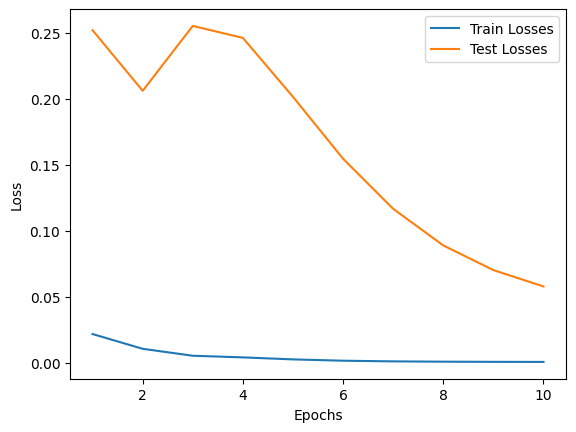

In [ ]:
# Convert tensors to NumPy arrays or keep them as is if already in NumPy format
train_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
test_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses]

# If epochs is a list of integers, use it directly
# Now you can plot the values
plt.plot(epochs, train_losses[2:], label='Train Losses')
plt.plot(epochs, test_losses[2:], label='Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


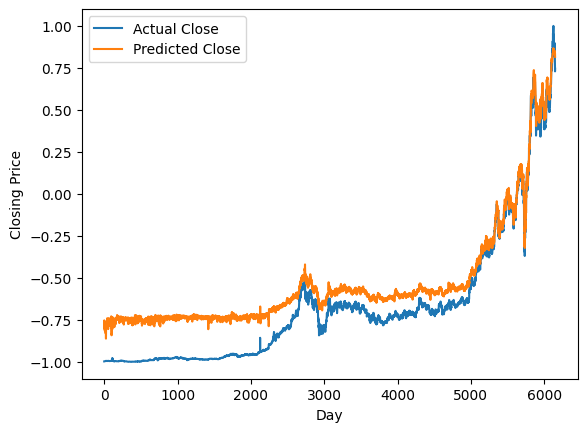

In [ ]:
with torch.no_grad():
  predicted_train = model(X_train.float().to(device)).cpu()
plt.plot(y_train,label='Actual Close')
plt.plot(predicted_train,label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

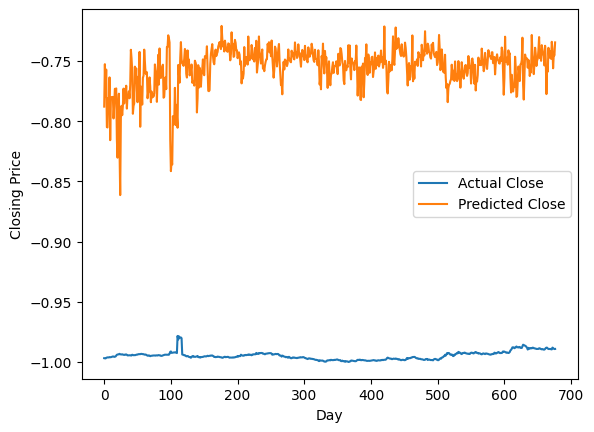

In [ ]:
with torch.no_grad():
  predicted = model(X_test.to(device).float()).cpu().numpy()
plt.plot(y_test,label='Actual Close')
plt.plot(predicted,label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
test_dataset = StocksDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
  sequence = item["sequence"]
  label = item["label"]

  _,output = model(sequence.unsqueeze(dim = 0))
  predictions.append(output.item())
  labels.append(label.item())

In [ ]:
len(predictions)

In [ ]:
len(test_df) - SEQUENCE_LENGTH

In [ ]:
test_df.head()

In [ ]:
scaler.min_, scaler.scale_

In [ ]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-3], scaler.scale_[-3]

In [ ]:
def descale(descaler, values):
  values_2d = np.array(values)[:, np.newaxis]
  return descaler.inverse_transform(values_2d).flatten()

In [ ]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [ ]:
predictions_descaled[:5]

In [ ]:
test_data = df[train_size:]
len(test_data), len(test_df)

In [ ]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
len(test_sequences_data), len(test_sequences)

In [ ]:
import matplotlib.dates as mdates

In [ ]:
import matplotlib.dates as mdates

# Convert dates to numerical format
dates = mdates.date2num(test_sequences_data.Date.tolist())

# Use plt.plot instead of plt.plot_dates
plt.plot(dates, predictions_descaled, "-", label="predicted")
plt.plot(dates, labels_descaled, "-", label="actual")

# Format the x-axis to show dates properly
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()
plt.show()
